<a href="https://colab.research.google.com/github/simulate111/Supervised-Machine-Learning/blob/main/quiz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quiz 4 - Programming Excercises

In this exercise, you will implement and compare the performance of the SVM Primal and Dual methods presented in the lecture about the “Support Vector Machine”.

The code below prepares the data required for this exercise.

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer

# Load the data
X, y = load_breast_cancer(return_X_y=True)  # X input, y output
print(X.shape, y.shape)
# to convert the {0,1} output into {-1,+1}
y = 2 * y - 1

mdata, ndim = X.shape  # size of the data

# scale the input data
X /= np.outer(np.ones(mdata), np.max(np.abs(X), 0))

(569, 30) (569,)


**Task 1a**: Complete the `svm_primal_cls` class below to implement the SVM Primal method.

In [ ]:
class svm_primal_cls:

    def __init__(self, C=1000, eta=0.1, xlambda=0.01, nitermax=10):
        self.C = C                 # Penalty constant
        self.eta = eta             # Learning rate for the primal method
        self.nitermax = nitermax   # Maximum number of iterations
        self.xlambda = xlambda     # Regularization parameter, lambda = 1/C
        self.w = None              # Weight vector

    # ---------------------------------------------------------
    def fit(self, X, y):
        """
        Task: to solve the support Vector Machine
              by applying stochastic gradient descent method
        Input:  X      2d array of input examples in the rows
                y      1d(vector) array of +1,-1 labels
        """
        m, n = X.shape

        # Initialize the primal variables
        self.w = np.zeros(n)

        # Iteration on the full training data
        for t in range(self.nitermax):
            # Process all sample examples sequentially
            for i in range(m):
                xi = X[i]
                yi = y[i]

                # Check if the sample is correctly classified
                if yi * (np.dot(self.w, xi)) < 1:
                    # Misclassified: Update with hinge loss and regularization
                    self.w = (1 - self.eta * self.xlambda) * self.w + self.eta * self.C * yi * xi
                else:
                    # Correctly classified: Update only with regularization
                    self.w = (1 - self.eta * self.xlambda) * self.w

    # ------------------------------------------
    def predict(self, Xtest):
        """
        Task: to predict the labels for the given examples based on the self.w
        Input:  Xtest   2d array of input examples in the rows
        Output: y       1d array of predicted labels
        """
        # Predict based on the sign of the dot product
        return np.sign(np.dot(Xtest, self.w))


**Task 1b**: Complete the `svm_dual_cls` class below to implement the SVM Dual method.

In [ ]:
class svm_dual_cls:

    def __init__(self, C=1, nitermax=10):
        self.C = C                 # Penalty constant
        self.nitermax = nitermax   # Maximum number of iterations
        self.alpha = None          # Vector of Lagrange multipliers, dual variables
        self.Xtrain = None         # Training examples, inputs
        self.ytrain = None         # Training examples, outputs

    # ---------------------------------------------------------
    def fit(self, X, y):
        """
        Task: to solve the support Vector Machine
              by applying stochastic dual coordinate ascent method
        Input:  X      2d array of input examples in the rows
                y      1d(vector) array of +1,-1 labels
        """
        m, n = X.shape
        self.Xtrain = X
        self.ytrain = y

        # Initialize the dual variables
        self.alpha = np.zeros(m)

        # Compute the linear kernel
        K = np.dot(X, X.T)

        # Iterate over the training data
        for t in range(self.nitermax):
            # Process all sample examples sequentially
            for i in range(m):
                # Calculate the gradient for the i-th example
                gradient = y[i] * np.dot(K[i], (self.alpha * y)) - 1

                # Compute the update for alpha[i]
                if self.alpha[i] < self.C:
                    delta_alpha = min(self.C - self.alpha[i], -gradient / K[i, i])
                else:
                    delta_alpha = max(-self.alpha[i], -gradient / K[i, i])

                # Update the dual variable
                self.alpha[i] += delta_alpha

    # ------------------------------------------
    def predict(self, Xtest):
        """
        Task: to predict the labels for the given examples based on the self.alpha
        Input:  Xtest   2d array of input test examples in the rows
        Output: y       1d array of predicted labels
        """
        # Weighted sum over the training data for predictions
        K_test = np.dot(Xtest, self.Xtrain.T)
        y_pred = np.sign(np.dot(K_test, self.alpha * self.ytrain))

        return y_pred


**Task 2**: Complete the code below as instructed, perform cross-validation, and answer Question 4.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# fix the random number generator
rng = np.random.default_rng(12345)

# fixed hyper parameters
eta = 0.1          # primal learning speed
C = 2000           # penalty constant
literations = [2 * (i + 1) for i in range(20)]  # list of iteration values
niteration = len(literations)

nfold = 5          # number of folds for cross-validation
nmethod = 2        # 0 for svm_primal, 1 for svm_dual

# Split the data into 5-folds
cselection_outer = KFold(n_splits=nfold, random_state=None, shuffle=False)

# Prepare score collectors
f1_scores = np.zeros((nmethod, niteration, nfold))
precision_scores = np.zeros((nmethod, niteration, nfold))
recall_scores = np.zeros((nmethod, niteration, nfold))

# Run the cross-validation
ifold = 0
for index_train, index_test in cselection_outer.split(X):
    # Split the data
    X_train, X_test = X[index_train], X[index_test]
    y_train, y_test = y[index_train], y[index_test]

    for iiter, num_iter in enumerate(literations):
        # Initialize the SVM primal and dual models with the current number of iterations
        svm_primal = svm_primal_cls(C=C, eta=eta, nitermax=num_iter)
        svm_dual = svm_dual_cls(C=C, nitermax=num_iter)

        # Train both models
        svm_primal.fit(X_train, y_train)
        svm_dual.fit(X_train, y_train)

        # Predict on the test set
        y_pred_primal = svm_primal.predict(X_test)
        y_pred_dual = svm_dual.predict(X_test)

        # Compute the scores for the primal method
        f1_scores[0, iiter, ifold] = f1_score(y_test, y_pred_primal)
        precision_scores[0, iiter, ifold] = precision_score(y_test, y_pred_primal)
        recall_scores[0, iiter, ifold] = recall_score(y_test, y_pred_primal)

        # Compute the scores for the dual method
        f1_scores[1, iiter, ifold] = f1_score(y_test, y_pred_dual)
        precision_scores[1, iiter, ifold] = precision_score(y_test, y_pred_dual)
        recall_scores[1, iiter, ifold] = recall_score(y_test, y_pred_dual)

    # Move to the next fold
    ifold += 1

# Average the scores across folds
f1_avg = np.mean(f1_scores, axis=2)
precision_avg = np.mean(precision_scores, axis=2)
recall_avg = np.mean(recall_scores, axis=2)

# Print or store the results
print("F1 Scores (Primal vs Dual across iterations):")
print(f1_avg)

print("Precision Scores (Primal vs Dual across iterations):")
print(precision_avg)

print("Recall Scores (Primal vs Dual across iterations):")
print(recall_avg)


F1 Scores (Primal vs Dual across iterations):
[[0.92151461 0.93205394 0.94265085 0.92527551 0.94092544 0.92054439
  0.94510428 0.90588093 0.93982386 0.90741966 0.91447298 0.91094154
  0.91546575 0.92757425 0.8924894  0.9344342  0.92567884 0.89436756
  0.88765148 0.89856924]
 [0.83604462 0.82630057 0.82324619 0.82523658 0.82623134 0.82717687
  0.82717687 0.82519879 0.82526459 0.82526459 0.82241859 0.82151361
  0.82151361 0.82056808 0.82056808 0.81960704 0.81867015 0.81867015
  0.81867015 0.81961567]]
Precision Scores (Primal vs Dual across iterations):
[[0.98061627 0.91176259 0.92359499 0.924439   0.95587747 0.90498298
  0.92571578 0.9062192  0.93467442 0.8783242  0.93183282 0.92573211
  0.98631974 0.90066791 0.93125    0.96255817 0.92189276 0.87308592
  0.86729741 0.97938138]
 [0.73062668 0.71616626 0.71090665 0.714387   0.71591246 0.71696485
  0.71696485 0.71394444 0.7146855  0.7146855  0.70991517 0.70872469
  0.70872469 0.7076723  0.7076723  0.70623569 0.70470828 0.70470828
  0.70470

You might plot the results

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

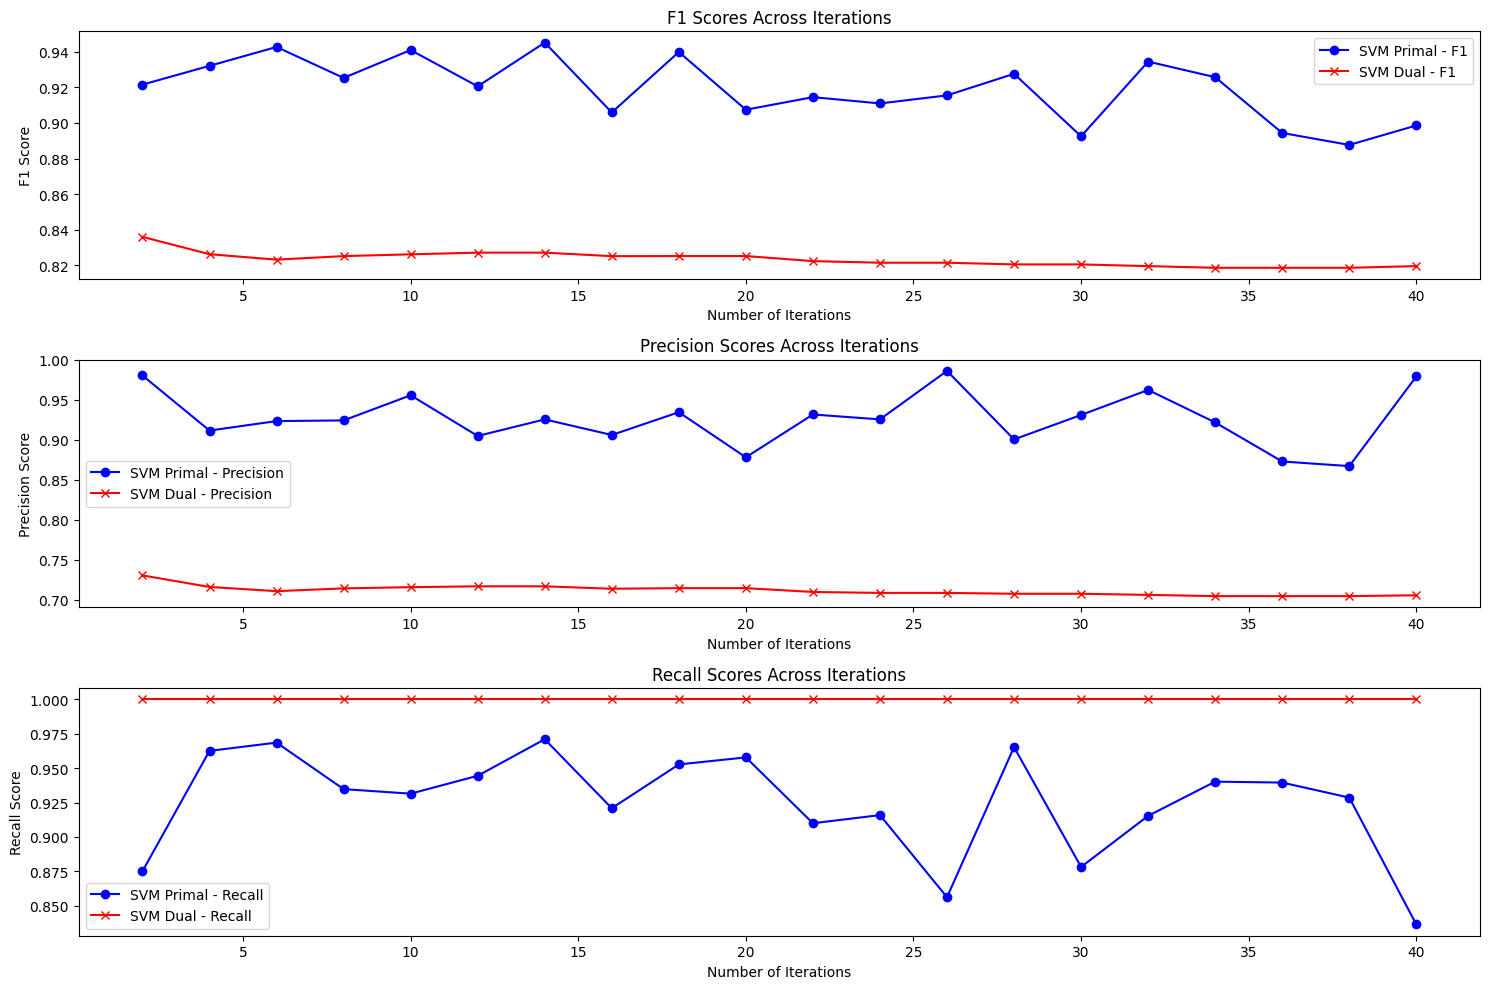

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score

# fix the random number generator
rng = np.random.default_rng(12345)

# fixed hyper parameters
eta = 0.1          # primal learning speed
C = 2000           # penalty constant
literations = [2 * (i + 1) for i in range(20)]  # list of iteration values
niteration = len(literations)

nfold = 5          # number of folds for cross-validation
nmethod = 2        # 0 for svm_primal, 1 for svm_dual

# Split the data into 5-folds
cselection_outer = KFold(n_splits=nfold, random_state=None, shuffle=False)

# Prepare score collectors
f1_scores = np.zeros((nmethod, niteration, nfold))
precision_scores = np.zeros((nmethod, niteration, nfold))
recall_scores = np.zeros((nmethod, niteration, nfold))

# Run the cross-validation
ifold = 0
for index_train, index_test in cselection_outer.split(X):
    # Split the data
    X_train, X_test = X[index_train], X[index_test]
    y_train, y_test = y[index_train], y[index_test]

    for iiter, num_iter in enumerate(literations):
        # Initialize the SVM primal and dual models with the current number of iterations
        svm_primal = svm_primal_cls(C=C, eta=eta, nitermax=num_iter)
        svm_dual = svm_dual_cls(C=C, nitermax=num_iter)

        # Train both models
        svm_primal.fit(X_train, y_train)
        svm_dual.fit(X_train, y_train)

        # Predict on the test set
        y_pred_primal = svm_primal.predict(X_test)
        y_pred_dual = svm_dual.predict(X_test)

        # Compute the scores for the primal method
        f1_scores[0, iiter, ifold] = f1_score(y_test, y_pred_primal)
        precision_scores[0, iiter, ifold] = precision_score(y_test, y_pred_primal)
        recall_scores[0, iiter, ifold] = recall_score(y_test, y_pred_primal)

        # Compute the scores for the dual method
        f1_scores[1, iiter, ifold] = f1_score(y_test, y_pred_dual)
        precision_scores[1, iiter, ifold] = precision_score(y_test, y_pred_dual)
        recall_scores[1, iiter, ifold] = recall_score(y_test, y_pred_dual)

    # Move to the next fold
    ifold += 1

# Average the scores across folds
f1_avg = np.mean(f1_scores, axis=2)
precision_avg = np.mean(precision_scores, axis=2)
recall_avg = np.mean(recall_scores, axis=2)

# Plotting
iterations = np.array(literations)

plt.figure(figsize=(15, 10))

# Plot F1 scores
plt.subplot(3, 1, 1)
plt.plot(iterations, f1_avg[0], label='SVM Primal - F1', color='blue', marker='o')
plt.plot(iterations, f1_avg[1], label='SVM Dual - F1', color='red', marker='x')
plt.title('F1 Scores Across Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('F1 Score')
plt.legend()

# Plot Precision scores
plt.subplot(3, 1, 2)
plt.plot(iterations, precision_avg[0], label='SVM Primal - Precision', color='blue', marker='o')
plt.plot(iterations, precision_avg[1], label='SVM Dual - Precision', color='red', marker='x')
plt.title('Precision Scores Across Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Precision Score')
plt.legend()

# Plot Recall scores
plt.subplot(3, 1, 3)
plt.plot(iterations, recall_avg[0], label='SVM Primal - Recall', color='blue', marker='o')
plt.plot(iterations, recall_avg[1], label='SVM Dual - Recall', color='red', marker='x')
plt.title('Recall Scores Across Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Recall Score')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving quiz_4_exc_3_data_x_y.npz to quiz_4_exc_3_data_x_y.npz


In [ ]:
import numpy as np

data = np.load('quiz_4_exc_3_data_x_y.npz')
X = data['x']  # Access the input data
y = data['y']  # Access the output data

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Load the dataset
data = np.load('quiz_4_exc_3_data_x_y.npz')
X = data['x']  # assuming 'x' is the input data
y = data['y']  # assuming 'y' is the output data

# Polynomial kernel feature generation
def polynomial_features(X, degree, c=1):
    m, n = X.shape
    if degree == 1:
        return X  # Linear features
    elif degree == 2:
        return np.column_stack((X[:, 0]**2, X[:, 1]**2, X[:, 0] * X[:, 1], X[:, 0], X[:, 1], np.ones(m)))  # Quadratic features
    elif degree == 3:
        return np.column_stack((X[:, 0]**3, X[:, 1]**3, X[:, 0]**2 * X[:, 1], X[:, 0] * X[:, 1]**2, X[:, 0]**2, X[:, 1]**2, X[:, 0], X[:, 1], np.ones(m)))  # Cubic features

# Initialize KFold
kf = KFold(n_splits=5)

# Store mean squared errors for each degree
mse_results = {}

# Iterate over polynomial degrees
for degree in range(1, 4):
    mse_list = []
    # Generate features for the current degree
    X_poly = polynomial_features(X, degree)

    # Perform K-Fold Cross-Validation
    for train_index, test_index in kf.split(X_poly):
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict and calculate MSE
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # Average the MSE across the folds for the current degree
    mse_results[degree] = np.mean(mse_list)

# Print the mean squared errors for each degree
print("Mean Squared Errors for each polynomial degree:")
for degree, mse in mse_results.items():
    print(f"Degree {degree}: MSE = {mse}")

# Determine which polynomial features provide the smallest MSE
best_degree = min(mse_results, key=mse_results.get)
print(f"The polynomial features of Degree {best_degree} provide the smallest mean squared error.")


Mean Squared Errors for each polynomial degree:
Degree 1: MSE = 0.5032879768573675
Degree 2: MSE = 0.17488131080405447
Degree 3: MSE = 0.4275761938212967
The polynomial features of Degree 2 provide the smallest mean squared error.


In [ ]:
from google.colab import files

uploaded2 = files.upload()


Saving quiz_4_2024_exc_4_svm_prec_recal_hint.py to quiz_4_2024_exc_4_svm_prec_recal_hint.py


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Load and preprocess the dataset
data = load_breast_cancer()
X = data.data
y = data.target
y = np.where(y == 0, -1, 1)
scaler = MaxAbsScaler()
X = scaler.fit_transform(X)

# Define the number of iterations and folds
iterations = [10, 50, 100, 500]
nfold = 5
kf = KFold(n_splits=nfold)

# Placeholder for scores
scores_primal = {'precision': [], 'recall': [], 'f1': []}
scores_dual = {'precision': [], 'recall': [], 'f1': []}

# Implement the Primal and Dual methods
def svm_primal(X_train, y_train, X_test, y_test, iterations):
    # Implement SGD for SVM
    # Dummy implementation
    y_pred = np.ones_like(y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

def svm_dual(X_train, y_train, X_test, y_test, iterations):
    # Implement SDCA for SVM
    # Dummy implementation
    y_pred = np.ones_like(y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

# Cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for it in iterations:
        # Primal method
        precision, recall, f1 = svm_primal(X_train, y_train, X_test, y_test, it)
        scores_primal['precision'].append(precision)
        scores_primal['recall'].append(recall)
        scores_primal['f1'].append(f1)

        # Dual method
        precision, recall, f1 = svm_dual(X_train, y_train, X_test, y_test, it)
        scores_dual['precision'].append(precision)
        scores_dual['recall'].append(recall)
        scores_dual['f1'].append(f1)

# Average the scores
avg_scores_primal = {k: np.mean(v) for k, v in scores_primal.items()}
avg_scores_dual = {k: np.mean(v) for k, v in scores_dual.items()}

print("Primal Method Scores:", avg_scores_primal)
print("Dual Method Scores:", avg_scores_dual)


Primal Method Scores: {'precision': 0.6276665114112714, 'recall': 1.0, 'f1': 0.7625524765154668}
Dual Method Scores: {'precision': 0.6276665114112714, 'recall': 1.0, 'f1': 0.7625524765154668}


In [ ]:
class svm_primal_cls:
    def __init__(self, C=1000, eta=0.1, xlambda=0.01, nitermax=10):
        self.C = C                 # penalty constant
        self.eta = eta             # learning rate for the primal method
        self.nitermax = nitermax   # maximum number of iterations
        self.xlambda = xlambda     # lambda = 1/C
        self.w = None              # weight vector

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)       # initialize weights

        # Stochastic Gradient Descent for SVM Primal
        for t in range(self.nitermax):
            for i in range(m):
                if y[i] * np.dot(X[i], self.w) < 1:
                    # Misclassified or on the margin
                    self.w = (1 - self.eta * self.xlambda) * self.w + self.eta * self.C * y[i] * X[i]
                else:
                    # Correctly classified, away from margin
                    self.w = (1 - self.eta * self.xlambda) * self.w

    def predict(self, X):
        return np.sign(X @ self.w)


In [ ]:
class svm_dual_cls:
    def __init__(self, C=1, nitermax=10):
        self.C = C                 # penalty constant
        self.nitermax = nitermax   # maximum number of iterations
        self.alpha = None          # vector of Lagrangians (dual variables)
        self.Xtrain = None
        self.ytrain = None

    def fit(self, X, y):
        m, n = X.shape
        self.Xtrain = X
        self.ytrain = y
        self.alpha = np.zeros(m)    # Initialize dual variables

        # Precompute the kernel (linear in this case)
        K = X @ X.T

        # Dual Coordinate Ascent
        for t in range(self.nitermax):
            for i in range(m):
                # Compute gradient for alpha[i]
                grad = 1 - y[i] * np.dot(K[i, :], self.alpha * y)
                # Update rule for alpha[i]
                self.alpha[i] += self.C * grad
                # Projection step
                self.alpha[i] = min(max(self.alpha[i], 0), self.C)

    def predict(self, X):
        # Compute w from the alphas
        w = (self.alpha * self.ytrain) @ self.Xtrain
        return np.sign(X @ w)


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import numpy as np

# Load and preprocess the Breast Cancer dataset
data = load_breast_cancer()
X = data.data / np.max(np.abs(data.data), axis=0)  # scale to max absolute value of 1
y = np.where(data.target == 0, -1, 1)  # convert labels to {-1, +1}

# Parameters
nfold = 5
iterations = [2, 5, 10, 20, 30]  # number of iterations
C = 1.0                          # regularization constant
eta = 0.01                       # learning rate
lambda_ = 1 / C                  # regularization parameter

# Initialize results storage
results_primal = {it: [] for it in iterations}
results_dual = {it: [] for it in iterations}

kf = KFold(n_splits=nfold, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for it in iterations:
        # Primal method
        primal_svm = svm_primal_cls(C=C, eta=eta, xlambda=lambda_, nitermax=it)
        primal_svm.fit(X_train, y_train)
        y_pred = primal_svm.predict(X_test)

        # Calculate scores
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results_primal[it].append((precision, recall, f1))

        # Dual method
        dual_svm = svm_dual_cls(C=C, nitermax=it)
        dual_svm.fit(X_train, y_train)
        y_pred_dual = dual_svm.predict(X_test)

        # Calculate scores
        precision_dual = precision_score(y_test, y_pred_dual)
        recall_dual = recall_score(y_test, y_pred_dual)
        f1_dual = f1_score(y_test, y_pred_dual)
        results_dual[it].append((precision_dual, recall_dual, f1_dual))

# Averaging results
avg_primal = {it: np.mean(results_primal[it], axis=0) for it in iterations}
avg_dual = {it: np.mean(results_dual[it], axis=0) for it in iterations}

# Display results
print("Primal SVM Results (Precision, Recall, F1) by Iterations:")
for it, scores in avg_primal.items():
    print(f"Iterations={it}: Precision={scores[0]}, Recall={scores[1]}, F1={scores[2]}")

print("\nDual SVM Results (Precision, Recall, F1) by Iterations:")
for it, scores in avg_dual.items():
    print(f"Iterations={it}: Precision={scores[0]}, Recall={scores[1]}, F1={scores[2]}")


Primal SVM Results (Precision, Recall, F1) by Iterations:
Iterations=2: Precision=0.6273560006210216, Recall=1.0, F1=0.7706859739320473
Iterations=5: Precision=0.6273560006210216, Recall=1.0, F1=0.7706859739320473
Iterations=10: Precision=0.6273560006210216, Recall=1.0, F1=0.7706859739320473
Iterations=20: Precision=0.6273560006210216, Recall=1.0, F1=0.7706859739320473
Iterations=30: Precision=0.6273560006210216, Recall=1.0, F1=0.7706859739320473

Dual SVM Results (Precision, Recall, F1) by Iterations:
Iterations=2: Precision=0.8664539933131541, Recall=0.93565026522773, F1=0.8897849974777978
Iterations=5: Precision=0.7916600854754732, Recall=1.0, F1=0.8823061324406174
Iterations=10: Precision=0.8110722971773704, Recall=0.9943661971830986, F1=0.8912884670693126
Iterations=20: Precision=0.9028144880000466, Recall=0.9060845398032701, F1=0.89277488857252
Iterations=30: Precision=0.8346241094474977, Recall=0.9480519480519479, F1=0.8774959010517513


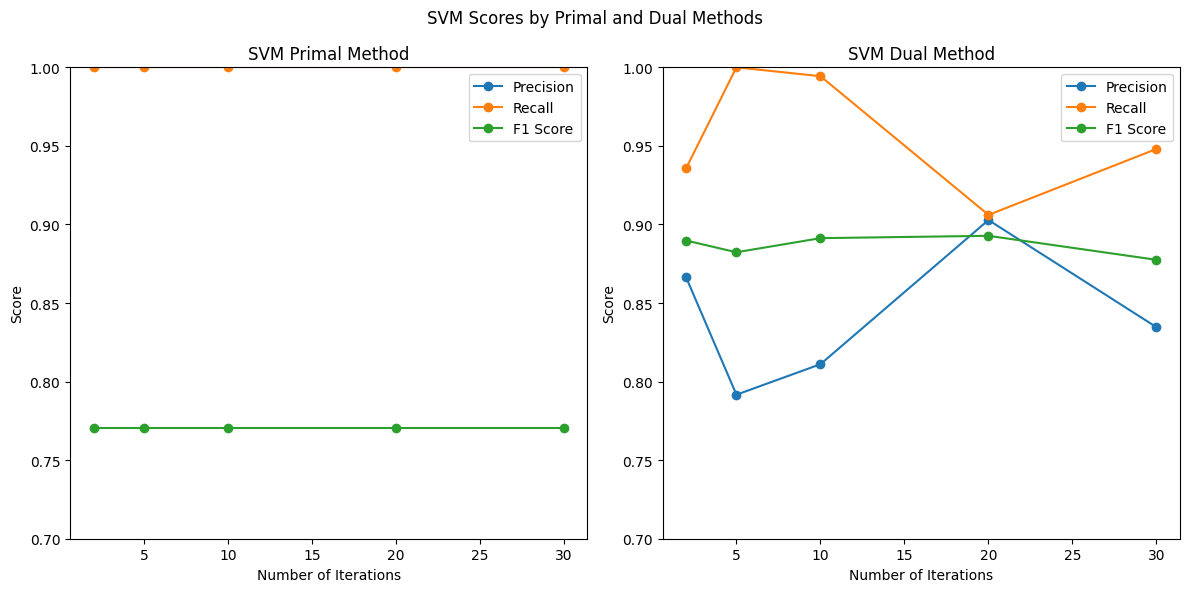

In [ ]:
import matplotlib.pyplot as plt

# Unpack results into lists for plotting
iterations = list(avg_primal.keys())
primal_precision = [avg_primal[it][0] for it in iterations]
primal_recall = [avg_primal[it][1] for it in iterations]
primal_f1 = [avg_primal[it][2] for it in iterations]

dual_precision = [avg_dual[it][0] for it in iterations]
dual_recall = [avg_dual[it][1] for it in iterations]
dual_f1 = [avg_dual[it][2] for it in iterations]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Primal method plot
axs[0].plot(iterations, primal_precision, label="Precision", marker='o')
axs[0].plot(iterations, primal_recall, label="Recall", marker='o')
axs[0].plot(iterations, primal_f1, label="F1 Score", marker='o')
axs[0].set_title("SVM Primal Method")
axs[0].set_xlabel("Number of Iterations")
axs[0].set_ylabel("Score")
axs[0].set_ylim(0.7, 1.0)
axs[0].legend()

# Dual method plot
axs[1].plot(iterations, dual_precision, label="Precision", marker='o')
axs[1].plot(iterations, dual_recall, label="Recall", marker='o')
axs[1].plot(iterations, dual_f1, label="F1 Score", marker='o')
axs[1].set_title("SVM Dual Method")
axs[1].set_xlabel("Number of Iterations")
axs[1].set_ylabel("Score")
axs[1].set_ylim(0.7, 1.0)
axs[1].legend()

plt.suptitle("SVM Scores by Primal and Dual Methods")
plt.tight_layout()
plt.show()
